# Unexpected damage on a particular class of assets has been observed, what has been going on?

We've got a collection of data that has been collected across various assets and will help to determine what is happening and inform what the next actions should be. 

The code will be structured as follows:
- Data cleansing and summary
- Model run
- Model validation
- Recommendations about actions (if any)

***

# Libraries

In [1]:
# Libraries:
import numpy as np
import pandas as pd
import pystan as stan
import stanity
import pickle

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

# Functions

Trace plotting function adapted from https://github.com/mwestt/An-Introduction-to-Bayesian-Inference-in-PyStan/blob/master/PyStan_plotting.py

In [72]:
#trace plots of MCMC runs
def plot_trace(param, param_name='parameter'):
    """Plot the trace and posterior of a parameter."""
    
    # Summary statistics
    mean = np.mean(param)
    median = np.median(param)
    cred_min, cred_max = np.percentile(param, 5), np.percentile(param, 95)
    
    # Plotting
    plt.subplot(2,1,1)
    plt.plot(param)
    plt.xlabel('samples')
    plt.ylabel(param_name)
    plt.axhline(mean, color='r', lw=2, linestyle='--')
    plt.axhline(median, color='c', lw=2, linestyle='--')
    plt.axhline(cred_min, linestyle=':', color='k', alpha=0.2)
    plt.axhline(cred_max, linestyle=':', color='k', alpha=0.2)
    plt.title('Trace and Posterior Distribution for {}'.format(param_name))

    plt.subplot(2,1,2)
    plt.hist(param, 30, density=True); sns.kdeplot(param, shade=True)
    plt.xlabel(param_name)
    plt.ylabel('density')
    plt.axvline(mean, color='r', lw=2, linestyle='--',label='mean')
    plt.axvline(median, color='c', lw=2, linestyle='--',label='median')
    plt.axvline(cred_min, linestyle=':', color='k', alpha=0.2, label=r'90\% CI')
    plt.axvline(cred_max, linestyle=':', color='k', alpha=0.2)
    
    plt.gcf().tight_layout()
    plt.legend()

#Plot posterior of the coefficient only
def plot_coeff(param, param_name='parameter'):
    # Summary statistics
    mean = np.mean(param)
    median = np.median(param)
    cred_min, cred_max = np.percentile(param, 5), np.percentile(param, 95)

    plt.hist(param, 30, density=True); sns.kdeplot(param, shade=True)
    plt.xlabel(param_name)
    plt.ylabel('density')
    plt.axvline(mean, color='r', lw=2, linestyle='--',label='mean')
    plt.axvline(median, color='c', lw=2, linestyle='--',label='median')
    plt.axvline(cred_min, linestyle=':', color='k', alpha=0.2, label=r'90\% CI')
    plt.axvline(cred_max, linestyle=':', color='k', alpha=0.2)

    plt.gcf().tight_layout()
    plt.legend()

# Processing the data
I noticed that in Year_sampled some dates were reported as years and others with specific days. I manually in Excel changed it all to be the format and only keep the year.

In [3]:
# Reading in data
Data_file = 'gas_sample_data.xlsx'
xl = pd.ExcelFile(Data_file)
sheets=xl.sheet_names

data = xl.parse(sheets[0]) # get gas_sample_data sheet
pd.set_option('display.max_columns', 200,'display.max_rows', 200) # settings to display all columns
data.columns = data.iloc[0] # set column names to be the variable names
data.drop(data.index[0],inplace=True) #Remove first row which had the variable names in
data = data.set_index('Asset').T #transpose data to make it easier to summaries; new format (ID * variables)
data.reset_index()
del data.index.name #delete index name to get one level column headings

data.describe() #Show summary of the data


Asset,Phase,Sampling Position,Damage_flag,Gas_1,Gas_2,Gas_3,Gas_4,Gas_5,Gas_6,Gas_7,Gas_8,Gas_9,Electrical_property_1,Electrical_property_2,Gas_10,Electrical_property_3,Pct_gas_6,Pct_gas_7,Pct_gas_9,gas9_to_gas7_ratio,gas6_to_gas1_ratio,gas7_to_gas8_ratio,gas4_to_gas5_ratio,gas2_to_gas3_ratio,age,Year_Installed,Year_sampled,Family,Attribute_1,Attribute_3,Attribute_4,Attribute_2
count,142,43,73,141.0,141,141,141.0,141.0,152,152.0,152.0,152.0,71,92.0000,149.0,116.0,77.000000,77.000000,77.0,77.0,66.0,77.0,66.000000,66.000000,83,124,125,122,125,63,81,39
unique,4,6,2,108.0,133,128,119.0,111.0,136,102.0,125.0,45.0,57,77.0000,77.0,53.0,76.000000,76.000000,74.0,68.0,64.0,69.0,66.000000,66.000000,10,13,3,6,3,5,2,3
top,Blue,Bottom,0,0.0,25000,81000,1100.0,540.0,44000,5.0,0.1,0.0,15000000000000,0.0001,10.0,22.0,0.993789,0.003106,0.0,1.0,0.5,1.0,28.152542,0.407564,18,1998,2016,A,132,630,DR,YT
freq,48,9,56,14.0,3,3,5.0,4.0,4,7.0,6.0,62.0,3,11.0000,8.0,13.0,2.000000,2.000000,3.0,6.0,2.0,8.0,1.000000,1.000000,18,21,73,45,76,18,42,18


The summary of the data shows that there are a lot of variables missing and we have a small data set of 155 observations. 
The variables of interest are:
- Asset and Family - to identify which asset group the asset belongs to, 
- Phase - each phase can be classed as a different asset, 
- Damage_flag - experts are sure that the damage flag is a good indicator of a problem, 
- Electrical_property_3 - engineers are sure that a low value (20-25) indicates a problem,
- age - engineers expect age to deteriorate the asset,
- Gas_10 - one engineer suspects that high values of Gas_10 migt indicate an issue with the asset.

We are not looking into other variables as a statistically sound model should take into account expert knowledge. Pure data exploration could lead to misleading results.

In [4]:
# re-calculate age to include all values
data['age']=data['Year_sampled']-data['Year_Installed']
data.loc[data.Family == 'NEW', 'age'] = 0

#delete all variables we are not focussing on
data.drop(['Sampling Position','Gas_1','Gas_2','Gas_3','Gas_4','Gas_5','Gas_6','Gas_7','Gas_8','Gas_9','Electrical_property_1',
           'Electrical_property_2','Pct_gas_6', 'Pct_gas_7', 'Pct_gas_9', 'gas9_to_gas7_ratio', 'gas6_to_gas1_ratio', 
           'gas7_to_gas8_ratio','gas4_to_gas5_ratio','gas2_to_gas3_ratio','Year_Installed', 'Year_sampled', 'Attribute_1', 
           'Attribute_3', 'Attribute_4', 'Attribute_2'],axis=1,inplace=True)

#re-code variables to a number and then make all columns numeric to make plotting easier
#Family
data.loc[data.Family == 'A', 'family'] = 1
data.loc[data.Family == 'B', 'family'] = 2
data.loc[data.Family == 'C', 'family'] = 3
data.loc[data.Family == 'D', 'family'] = 4
data.loc[data.Family == 'E', 'family'] = 5
data.loc[data.age == 0, 'family'] = 6

#Phase
data.loc[data.Phase == 'Red', 'phase'] = 1
data.loc[data.Phase == 'Yellow', 'phase'] = 2
data.loc[data.Phase == 'Blue', 'phase'] = 3

data.drop(['Family','Phase'],axis=1,inplace=True) #drop string column
data.rename({'Electrical_property_3': 'EP_3'},axis=1,inplace=True)

#Recode all variables as integers and make sure to keep nans
data=data.fillna(-999)
data=data.astype(int)
data=data.replace(-999, np.nan)

data.describe()

Asset,Damage_flag,Gas_10,EP_3,age,family,phase
count,73.000000,149.000000,116.000000,125.000000,122.000000,141.000000
mean,0.232877,62.000000,38.810345,15.672000,2.885246,2.014184
std,0.425589,34.615845,17.198541,7.156968,1.657424,0.819284
min,0.000000,8.000000,8.000000,0.000000,1.000000,1.000000
25%,0.000000,38.000000,22.000000,13.000000,1.000000,1.000000
50%,0.000000,65.000000,38.000000,14.000000,3.000000,2.000000
75%,0.000000,89.000000,51.250000,21.000000,4.000000,3.000000
max,1.000000,182.000000,97.000000,28.000000,6.000000,3.000000


In [5]:
#Proportion of each asset class in sample
t = data['family'].value_counts()/data['family'].count()
t

1.0    0.368852
4.0    0.303279
3.0    0.122951
5.0    0.098361
6.0    0.057377
2.0    0.049180
Name: family, dtype: float64

In [6]:
assets = xl.parse(sheets[2]) # get total asset data
assets.columns = assets.iloc[3] # set column names to be the variable names
assets.drop(assets.index[0],inplace=True) #Remove first row which had the variable names in
assets.drop([1,2,3,33],inplace=True)
Class_A=assets[['Age','A']].copy()
Class_A.dropna(inplace=True)
assets.replace(np.nan,0,inplace=True)
assets = assets * 3 #each asset has three phase that count as if it's a different asset alltogether
assets.drop('Age',axis=1).sum()/assets.drop('Age',axis=1).sum().sum()

3
A    0.238532
B    0.122936
C    0.174312
D    0.302752
E    0.161468
dtype: float64

The overall distribution of assets from the 'asset_population' tab in the data file is: A=24%	B=12%	C=17%	D=30%	E=16%
In the data we've got: : A=37%	B=5%	C=12%	D=30%	E=10% and NEW=6%
Thus, our sample is slightly biased.
***
## Missing value analysis

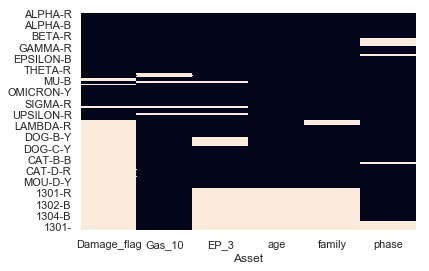

In [7]:
sns.heatmap(data.isnull(), cbar=False)

The last 30 observations don't have any values for the important variables that have been identified by engineers to indicate damage in an asset. Thus, we cannot use them and have to eliminate them even though this will shrink our data set. In theory it would be possible to impute the missing values, however, this would introduce a lot of uncertainty and we have a small data set to take values from.

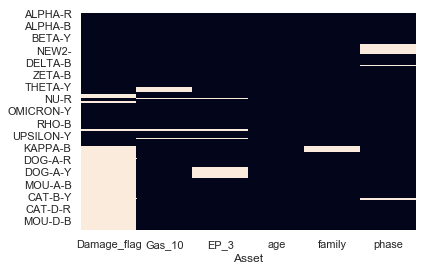

In [8]:
# Delete rows with assets that don't have any information for age, family, etc
data.dropna(subset=['age'],inplace=True)
sns.heatmap(data.isnull(), cbar=False)

We are left with scattered missing values across variables. Damage_flag shows the majority of the missing values. I will split the data set into two, one with damage flag and the other without. They can then be used to distinguish between assets that had an internal inspection as well as an oil sample taken and those that had only an oil sample taken.

In [27]:
#split the data set into two
data_damage = data.dropna(subset=['Damage_flag']).copy()

#delete two rows of data with Electrical_property_3 missing but keep three missing gas values for now [71 left]
data_damage.dropna(subset=['EP_3'],inplace=True)
data_damage.describe()

Asset,Damage_flag,Gas_10,EP_3,age,family,phase
count,71.000000,68.000000,71.000000,71.000000,71.000000,64.000000
mean,0.211268,70.823529,34.605634,12.774648,2.295775,2.062500
std,0.411113,29.816324,14.265321,5.814261,1.624758,0.814063
min,0.000000,28.000000,8.000000,0.000000,1.000000,1.000000
25%,0.000000,43.000000,22.000000,8.000000,1.000000,1.000000
50%,0.000000,67.500000,33.000000,14.000000,1.000000,2.000000
75%,0.000000,93.000000,47.500000,18.000000,3.000000,3.000000
max,1.000000,172.000000,60.000000,21.000000,6.000000,3.000000


There are still three missing values in Gas_10 left which I will keep for now.

In [10]:
#no damage inspection data
data_oil = data.drop(data[(data['Damage_flag'] == 1) | (data['Damage_flag'] == 0)].index).copy()
data_oil.drop('Damage_flag',axis=1,inplace=True)
data_oil.describe()

#delete 7 rows with missing values for Electrical_property_3 [45 left]
data_oil.dropna(subset=['EP_3'],inplace=True)

There are 3 values missing for Family which I will leave there for now.
#### In total we have 71 + 45 assets of usable data left from the original 155 
***

# Variables
Now, we've got a clean data set we can work with we will look at relationships between the variables.

Damage_flag       0.0       1.0
family                         
1.0          0.611111  0.388889
2.0          0.833333  0.166667
3.0          1.000000  0.000000
4.0          1.000000  0.000000
6.0          1.000000  0.000000


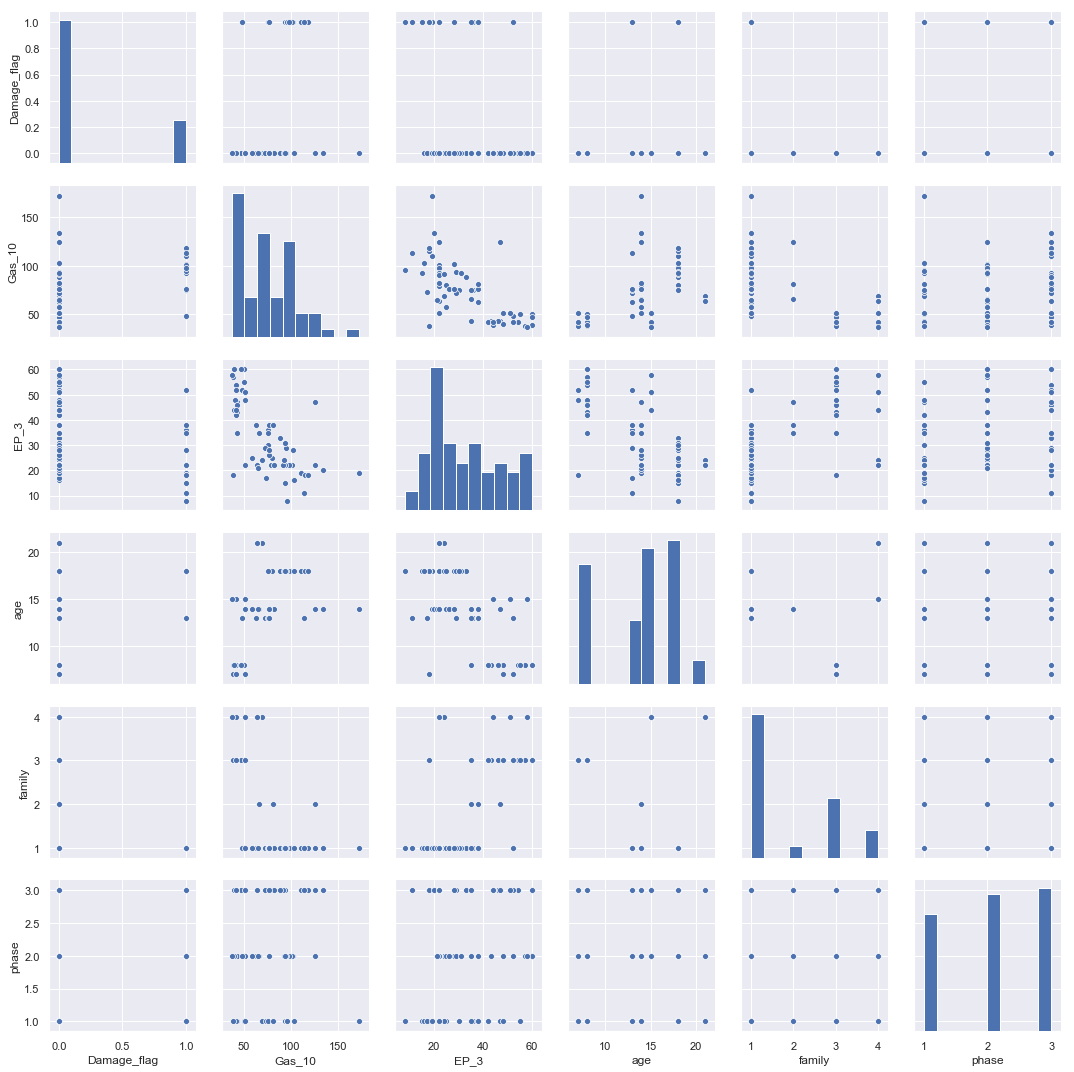

In [11]:
#Look at which asset class has damaged assets
print(pd.crosstab(data_damage['family'], data_damage['Damage_flag']).apply(lambda r: r/r.sum(), axis=1))
sns.pairplot(data_damage.dropna())

In [12]:
corr = data_damage.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(1)

Asset,Damage_flag,Gas_10,EP_3,age,family,phase
Asset,,,,,,
Damage_flag,1,0.4,-0.4,0.3,-0.4,-0.04
Gas_10,0.4,1,-0.7,0.6,-0.7,0.04
EP_3,-0.4,-0.7,1,-0.6,0.6,0.06
age,0.3,0.6,-0.6,1,-0.7,0.02
family,-0.4,-0.7,0.6,-0.7,1,0.1
phase,-0.04,0.04,0.06,0.02,0.1,1


- We can see that there are a couple of outliers in the Gas_10 variable.
- Electrical property 3 shows a peak around 20.
- Asset Family A and B are the only classes with at least one observed damage (B doesn't show in the chart because it's got some missing values in Gas_10). 
- The relationship between damage flag and the other variables is not clear.
- From the correlation heatmap we can see that there is positive correlation (0.6) between age and Gas_10 and negative correlation between electrical property 3 and age (-0.6) as well as Gas_10 (-0.7).

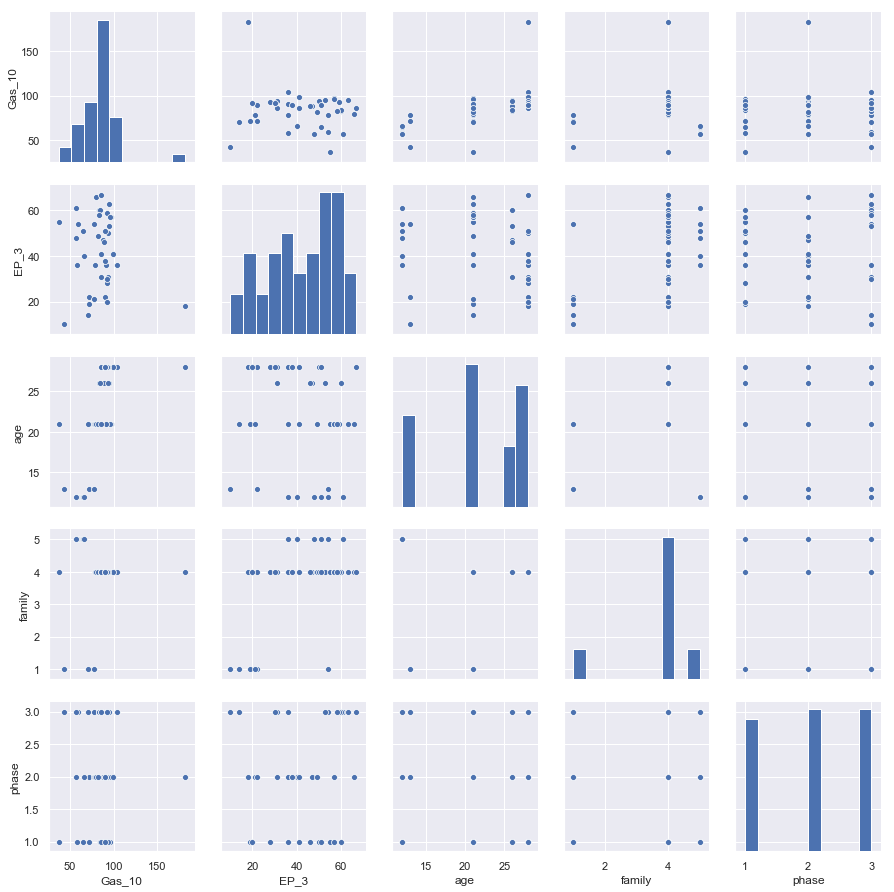

In [11]:
sns.pairplot(data_oil.dropna())

In [13]:
corr = data_oil.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(1)

Asset,Gas_10,EP_3,age,family,phase
Asset,,,,,
Gas_10,1,-0.5,0.8,0.1,0.002
EP_3,-0.5,1,-0.4,0.5,0.06
age,0.8,-0.4,1,0.1,-0.06
family,0.1,0.5,0.1,1,-0.1
phase,0.002,0.06,-0.06,-0.1,1


- Looking at the oil sample only data shows another outlier in the Gas_10 data. However, because we observe the same in the other data set I will leave it in for now because the model will be able to deal with it.
- The realtionship between age and Gas_10 is positive again and they are highly correlated.
- EP_3 and Gas_10 have not much of a shape to it but there is still a negative correlation at -0.5 observed.

***

# Model

We are going to run two versions of a Bayesian logit model with and without Gas_10 as only one engineer reported Gas_10 contributing to the damage of an asset we want to make sure we find the best variables describing damage:
1. damage ~ logistic(alpha + beta1 * EP_3 + beta2 * age + beta3 * Gas_10)
2. damage ~ logistic(alpha + beta1 * EP_3 + beta2 * age)

I won't include a variable for the family of assets as we have only observed damage in asset class A but want to learn if we should also test other classes of assets for damage. Out data set is very small with only 71 observations, dividing this by 6 asset classes in a hierarchical model as I would like to do ideally would be too much.

An important advantage of using a Bayesian approach is that it can include expert knowledge as prior information. As we only have a small data sample MCMC will ensure that simulations can indicate the level of uncertainty in the data.


## Model 1

In [177]:
#Damage data
Model_input_1 = data_damage[['Damage_flag','EP_3','age','Gas_10']].dropna().copy()
Model_input_1=Model_input_1.astype('int32')

#Oil sample only data (prediction)
Model_input_1_new = data_oil[['EP_3','age','Gas_10']].dropna().copy()
Model_input_1_new=Model_input_1_new.astype('int32')

#Input data for Stan model
mixture_data={'N':len(Model_input_1), 
              'damage':Model_input_1['Damage_flag'],
              'EP_3':Model_input_1['EP_3'],
              'age': Model_input_1['age'],
              'Gas_10':Model_input_1['Gas_10'],
              'N_new':len(Model_input_1_new),
              'EP_3_new':Model_input_1_new['EP_3'],
              'age_new': Model_input_1_new['age'],
              'Gas_10_new':Model_input_1_new['Gas_10']
             }

#Stan model
model_code = '''
data {
     int<lower=0> N; //number of data points
     int<lower=0,upper=1> damage[N]; //dependent variable
     int<lower=0> EP_3[N]; //independent variables
     int<lower=0> age[N]; 
     int<lower=0> Gas_10[N];
     
     //Oil sample data without damage flag
     int<lower=0> N_new;
     int<lower=0> EP_3_new[N_new]; 
     int<lower=0> age_new[N_new]; 
     int<lower=0> Gas_10_new[N_new];
}

parameters {
     real alpha;
     real beta_e;
     real beta_a;
     real beta_g;
}

model {
     //likelihood
     for (i in 1:N)
         damage[i] ~ bernoulli_logit(alpha + beta_e * EP_3[i] + beta_a * age[i] + beta_g * Gas_10[i]);
     
     //priors
     alpha ~ normal(0,1);
     beta_e ~ normal(20,5); //the engineers know a value between 20-25 indicates damage
     beta_a ~ normal(16,5); //the engineers assume assets deteriorate with age
     beta_g ~ normal(100,20); //the first engineer thought that a high gas_10 value indicates damage
}

generated quantities {
    vector[N_new] damage_pred;
    vector[N] log_lik; //calculate log-likelihood for model comparison
    
    //prediction of the oil sample data
    for (i in 1:N_new)
        damage_pred[i] = bernoulli_logit_rng(alpha + beta_e * EP_3_new[i] + beta_a * age_new[i] + beta_g * Gas_10_new[i]);
    
    //calculate log likelihood for LOO-CV comparion
    for (n in 1:N) 
        log_lik[n] = bernoulli_logit_lpmf(damage[n] | alpha + beta_e * EP_3[n] + beta_a * age[n] + beta_g * Gas_10[n]);
}
'''        
        
model = stan.StanModel(model_code=model_code)
fit = model.sampling(data=mixture_data,iter=8000,warmup=4000,chains=4)
#print(fit)

#Save compiled model and fit object for later use
with open("model_1_fit.pkl", "wb") as f:
    pickle.dump({'model' : model, 'fit' : fit}, f, protocol=-1)
    # or with a list
    # pickle.dump([model, fit], f, protocol=-1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_60c71bdb58684d79437539fa75bcddd7 NOW.
C:\Users\ea920664\AppData\Local\Continuum\anaconda3\envs\stan_env\lib\site-packages\ipykernel_launcher.py:76: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.


### Model 2 : without gas

In [178]:
Model_input_2 = data_damage[['Damage_flag','EP_3','age']].copy()
Model_input_2=Model_input_2.astype('int32')

#Oil sample only data (prediction)
Model_input_2_new = data_oil[['EP_3','age']].dropna().copy()
Model_input_2_new=Model_input_2_new.astype('int32')

#Input data for Stan model
mixture_data={'N':len(Model_input_2), 
              'damage':Model_input_2['Damage_flag'],
              'EP_3':Model_input_2['EP_3'],
              'age': Model_input_2['age'],
              'N_new':len(Model_input_2_new),
              'EP_3_new':Model_input_2_new['EP_3'],
              'age_new': Model_input_2_new['age']
             }

#Stan model
model_code = '''
data {
     int<lower=0> N; //number of data points
     int<lower=0,upper=1> damage[N]; //dependent variable
     int<lower=0> EP_3[N]; //independent variables
     int<lower=0> age[N]; 
     
     //Oil sample data without damage flag
     int<lower=0> N_new;
     int<lower=0> EP_3_new[N_new]; 
     int<lower=0> age_new[N_new]; 
}

parameters {
     real alpha;
     real beta_e;
     real beta_a;
}

model {
     //likelihood
     for (i in 1:N)
         damage[i] ~ bernoulli_logit(alpha + beta_e * EP_3[i] + beta_a * age[i]);
     
     //priors
     alpha ~ normal(0,1);
     beta_e ~ normal(20,5); //the engineers know a value between 20-25 indicates damage
     beta_a ~ normal(16,5); //the engineers assume assets deteriorate with age
}

generated quantities {
    vector[N_new] damage_pred;
    vector[N] log_lik; //calculate log-likelihood for model comparison
    
    //prediction of the oil sample data
    for (i in 1:N_new)
        damage_pred[i] = bernoulli_logit_rng(alpha + beta_e * EP_3_new[i] + beta_a * age_new[i]);
    
    //calculate log likelihood for LOO-CV comparion    
    for (n in 1:N) 
        log_lik[n] = bernoulli_logit_lpmf(damage[n] | alpha + beta_e * EP_3[n] + beta_a * age[n]);
}
'''        
        
model2 = stan.StanModel(model_code=model_code)
fit2 = model2.sampling(data=mixture_data,iter=8000,warmup=4000,chains=4)
#print(fit2)

#Save compiled model and fit object for later use
with open("model_2_fit.pkl", "wb") as f:
    pickle.dump({'model' : model2, 'fit' : fit2}, f, protocol=-1)
    # or with a list
    # pickle.dump([model, fit], f, protocol=-1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e0b81222476561b06491826452a6ab9a NOW.
C:\Users\ea920664\AppData\Local\Continuum\anaconda3\envs\stan_env\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.


## Assess predictive accuracy of each model
We want to know if high Gas_10 indicates damage or if the first engineer was mistaken. To do so we will use the leave-one-out cross validation (LOO-CV). According to Ben Lambert, 'A Student's guide to Bayesian statistics' this is the highest quality approximation for evaluating predictive accuracy.

In [15]:
#Load fit results for model 1
with open("model_1_fit.pkl", "rb") as f:
    data_dict = pickle.load(f)
fit1 = data_dict['fit']

#Load fit results for model 2
with open("model_2_fit.pkl", "rb") as f:
    data_dict = pickle.load(f)
fit2 = data_dict['fit']


#get likelihood
extracted = fit1.extract()
loo1 = stanity.psisloo(extracted['log_lik'])
print('elpd model 1: ',loo1.elpd)  #elpd (expected log pointwise predictive density)
#print(loo1.looic)  #looic
#print(loo1.print_summary()) #Numerical summary of pointwise Pareto-k indices --> Reports on frequency of observations with tail indices > 0.5 & 1

#get likelihood
extracted = fit2.extract()
loo2 = stanity.psisloo(extracted['log_lik'])
print('elpd model 2: ',loo2.elpd)  #elpd
#print(loo2.looic)  #looic
#print(loo2.print_summary()) #Numerical summary of pointwise Pareto-k indices --> Reports on frequency of observations with tail indices > 0.5 & 1

#Model comparison
comparison = stanity.loo_compare(loo1, loo2)  #diff: difference in elpd (estimated log predictive density) between two models, where a positive value indicates that model2 is a better fit than model1.
print(comparison) #We conclude that the first model (including gas) is the better fit with a higher elpd value

elpd model 1:  -32.34145516044502
elpd model 2:  -32.88275489180265
{'diff': -0.3402119592469255, 'se_diff': 7.1579587258085535}


It's not clear which model has performed better and we will look at the predictions each generated in more detail.

### Model 1 
Looking at MCMC trace plots and regression results in more detail.

Inference for Stan model: anon_model_60c71bdb58684d79437539fa75bcddd7.
4 chains, each with iter=8000; warmup=4000; thin=1; 
post-warmup draws per chain=4000, total post-warmup draws=16000.

                  mean se_mean     sd     5%    95%  n_eff   Rhat
alpha            -0.51    0.01   0.94  -2.04   1.03   8778    1.0
beta_e           -0.08  3.0e-4   0.03  -0.13  -0.03   8565    1.0
beta_a            0.04  9.6e-4   0.08  -0.09   0.17   6984    1.0
beta_g            0.01  1.5e-4   0.01  -0.01   0.03   7727    1.0
damage_pred[1]    0.28  3.5e-3   0.45    0.0    1.0  16276    1.0
damage_pred[2]    0.43  4.1e-3    0.5    0.0    1.0  14663    1.0
damage_pred[3]    0.05  1.7e-3   0.21    0.0    0.0  15667    1.0
damage_pred[4]  7.2e-3  6.7e-4   0.08    0.0    0.0  15866    1.0
damage_pred[5]   0.003  4.3e-4   0.05    0.0    0.0  16102    1.0
damage_pred[6]   0.003  4.3e-4   0.05    0.0    0.0  16105    1.0
damage_pred[7]    0.41  4.1e-3   0.49    0.0    1.0  14702    1.0
damage_pred[8]    

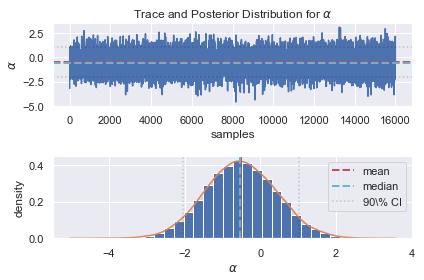

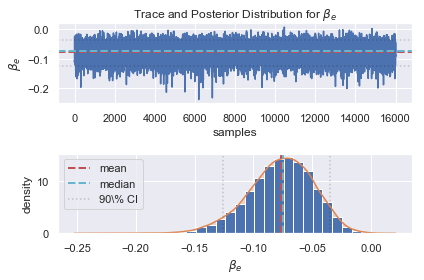

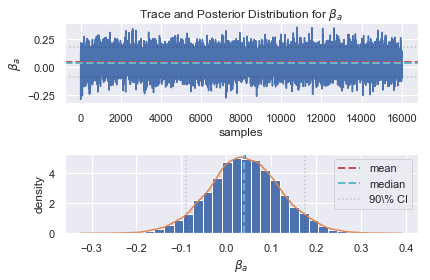

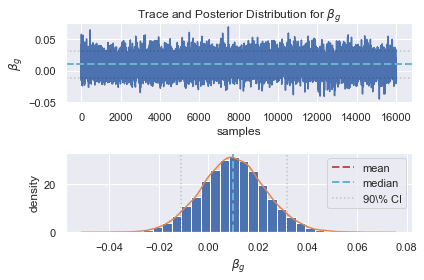

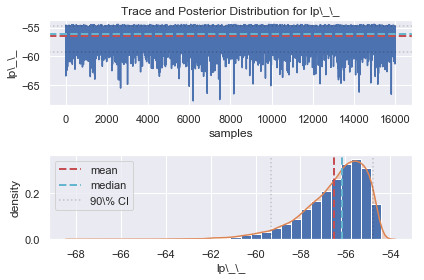

In [38]:
summary_1 = fit1.summary()

# Extracting traces
alpha_1 = fit1['alpha']
beta_e_1 = fit1['beta_e']
beta_a_1 = fit1['beta_a']
beta_g = fit1['beta_g']
lp_1 = fit1['lp__']

percentiles = (0.05,0.95)              # edit these at will\n",
print(stan.stansummary(fit1, probs=percentiles, digits_summary=2))

plot_trace(alpha_1, r'$\alpha$') 
plt.show()
plot_trace(beta_e_1, r'$\beta_e$') 
plt.show()
plot_trace(beta_a_1, r'$\beta_a$') 
plt.show()
plot_trace(beta_g, r'$\beta_g$') 
plt.show()
plot_trace(lp_1, r'lp\_\_') 
plt.show()

- Results for model 1 show that we are 90% certain that the coefficient for beta_g (Gas_10) can range from just under zero to 0.03. This is a very small effect and could potentially mean a high Gas_10 value actually very slightly decreases the occurance of damage.
- The age coefficient, beta_a, has a 90% credible interval that it lies between -0.09 and 0.17 which is a big range and indicates that age can sometimes reduce damage rather than increase it which is counter intuituve.
- The trace plots show that the model has converged

### Model 2
Looking at MCMC trace plots and regression results in more detail.

Inference for Stan model: anon_model_e0b81222476561b06491826452a6ab9a.
4 chains, each with iter=8000; warmup=4000; thin=1; 
post-warmup draws per chain=4000, total post-warmup draws=16000.

                  mean se_mean     sd     5%    95%  n_eff   Rhat
alpha           -0.331  0.0111 0.8927 -1.816 1.1454   6411 1.0001
beta_e          -0.080  0.0003 0.0272 -0.127 -0.038   6950 1.0000
beta_a          0.0929  0.0007 0.0558 0.0032 0.1865   6147 0.9998
damage_pred[1]  0.2934  0.0036 0.4553    0.0    1.0  15802 1.0003
damage_pred[2]  0.5117  0.0041 0.4998    0.0    1.0  14711 0.9998
damage_pred[3]  0.0418  0.0016 0.2003    0.0    0.0  15714 0.9999
damage_pred[4]   0.006  0.0006 0.0772    0.0    0.0  16203 0.9998
damage_pred[5]  0.0035  0.0004 0.0595    0.0    0.0  16122 0.9999
damage_pred[6]  0.0028  0.0004 0.0535    0.0    0.0  16094 1.0001
damage_pred[7]  0.5180  0.0041 0.4996    0.0    1.0  14488 1.0001
damage_pred[8]  0.4836  0.0040 0.4997    0.0    1.0  15359 0.9999
damage_pred[9]  0.

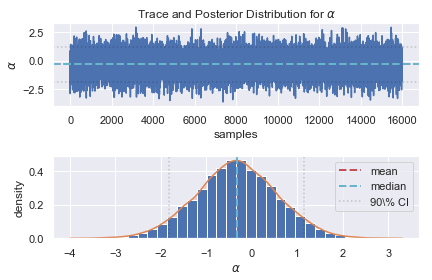

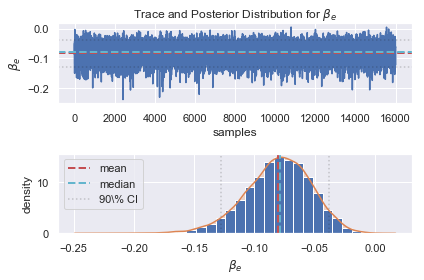

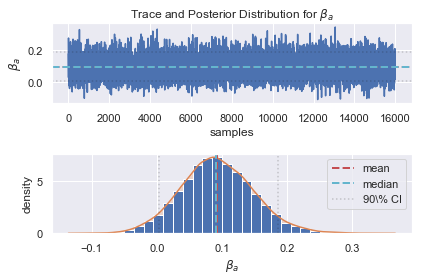

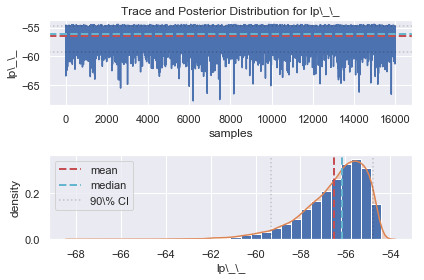

In [39]:
summary_2 = fit2.summary()

# Extracting traces
alpha_2 = fit2['alpha']
beta_e_2 = fit2['beta_e']
beta_a_2 = fit2['beta_a']
lp_2 = fit2['lp__']

#Print summary and trace plots
print(stan.stansummary(fit2, probs=percentiles, digits_summary=5))
plot_trace(alpha_2, r'$\alpha$') 
plt.show()
plot_trace(beta_e_2, r'$\beta_e$') 
plt.show()
plot_trace(beta_a_2, r'$\beta_a$') 
plt.show()
plot_trace(lp_1, r'lp\_\_') 
plt.show()

- Model 2 with only electrical property 3 and age as independent variables shows the expected results that a lower value in electrical property 3 leads to damage being more likely. A one unit increase in electrical property 3 leads to a reduction of the odds of damage by 7.7% (anything between -11.9% - (-3.7%) is within the 90% credible interval)
- One additional year of age increases the odds of damage on average by 9.7% (anything between 0.3%-20.5% is possible within the 90% credible interval)

## Compare predictive capabilities of the models
It is clear from the above that Model 1 produces unreasonable coefficients some of the time for age and Gas_10. A final check comparing the predictions from each model shows that Model 1 predicts 18% of the oil sample assets to be damaged and Model 2 predicts 22%. This is the average across 16,000 MCMC runs across 4 chains and mirrors what we have observed in the damage data very closely (21% observed damage).
#### I am thus confident that Model 2 (without Gas_10) is the better model as it predicts more damaged assets which we would want to know given the impact on the business and also because all coefficients are in the expected direction confirming the expert knowledge of the engineers.

In [26]:
print('Model 1 predicts',round(np.sum(fit1['damage_pred'])/(16000*45)*100,0),'% of assets to be damaged')
print('Model 2 predicts',round(np.sum(fit2['damage_pred'])/(16000*45)*100,0),'% of assets to be damaged')

Model 1 predicts 18.0 % of assets to be damaged
Model 2 predicts 22.0 % of assets to be damaged


***


## Model 2 prediction results

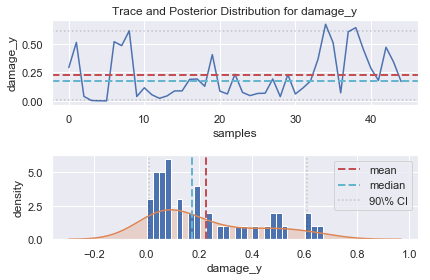

In [40]:
#Plot prediction trace and density for each individual
damage_pred=fit2['damage_pred']
damage_pred=pd.DataFrame(damage_pred).mean(axis=0)
damage_pred
plot_trace(damage_pred, 'damage_y') 
plt.show()

In [41]:
#Add predictions to the individual data
data_oil['damage_pred']=np.array(damage_pred)
data_oil['d_flag_pred']=0
data_oil.loc[data_oil.damage_pred >=0.4, 'd_flag_pred'] = 1
data_oil['d_flag_pred'].sum()

11

We count 11 assets out of 45 (24%) that are predicted to be damaged with a mean prediction of 0.5 or thereabouts (at least 0.4 or higher). 

I will look into asset class A in more detail now.

In [31]:
#Predicted damage by family
data_oil.replace(np.nan,999,inplace=True)
#pd.crosstab(data_oil['family'], data_oil['d_flag_pred'],margins=True)
pd.crosstab(data_oil['family'], data_oil['d_flag_pred']).apply(lambda r: r/r.sum(), axis=1)

d_flag_pred,0,1
family,,
1.0,0.333333,0.666667
4.0,0.766667,0.233333
5.0,1.000000,0.000000
999.0,1.000000,0.000000


In [32]:
#Asset class A==1 only by age
temp=data_oil.loc[data_oil['family'] == 1]
#pd.crosstab(temp['age'], temp['d_flag_pred'],margins=True)
pd.crosstab(temp['age'], temp['d_flag_pred']).apply(lambda r: r/r.sum(), axis=1)

d_flag_pred,0,1
age,,
13.0,0.666667,0.333333
21.0,0.000000,1.000000


We don't have data for all asset classes but class A shows that 4 out of 6 assest are predicted to be damaged. When looking at the age of the assets we can see that all 21 year old assets are predicted to be damaged while only 1 out of 3 of the 13 year old assets are predicted to be damaged.

In total we've got class A assets of age 9-22. I will calculate the odds of damage for each year and the percentage we expect to be damaged and will need replacement.

## Recommendation:
- Replace all assets that are predicted to be damaged for sure (£11,000) and replace if it's cheaper than doing damage inspections plus the required replacements
- Do damage inspection for all assets where the probability of damage is greater than 50% for all assets of that year
- Do oil sample for every other asset (mostly younger ones) plus the replacement rate if damage is predicted


In [67]:
#pass a dataframe and the coefficient we want to use to 
def calc_recommend(coeff,df,a13_dam_prob):
    """Calculate number of assets predicted to be damaged and cost of recommendation."""
  
    df['% damaged']=0
    df.loc[df.Age == 13, '% damaged'] = a13_dam_prob

    #apply model coefficient for later years
    for i in range(14,df['Age'].max()+1):
        if(df.loc[df['Age'] == (i-1),'% damaged'].iloc[0] + (coeff-1) > 1):
            df.loc[df.Age == i, '% damaged'] = 1
        else:
            df.loc[df.Age == i, '% damaged'] = df.loc[df['Age'] == (i-1),'% damaged'].iloc[0] + (coeff-1)    

    #apply model coefficient for earlier years
    for i in range(12,df['Age'].min()-1,-1):
        if(df.loc[df['Age'] == (i+1),'% damaged'].iloc[0] - (coeff-1))<0:
            df.loc[df.Age == i, '% damaged'] = 0
        else:
            df.loc[df.Age == i, '% damaged'] = df.loc[df['Age'] == (i+1),'% damaged'].iloc[0] - (coeff-1)    

    #Calculate the number of assets that are predicted to be damaged        
    df['n_assets']=(df['A']*df['% damaged']).astype(float).round(0).astype(int)

    #Costs for different options
    replacement_cost=11000
    damage_inspection_cost=950
    oil_sample_cost=140

    df['cost_replace_all']=df['A']*replacement_cost #Cost to replace all assets
    df['cost_report_repl']=df['n_assets']*replacement_cost+df['A']*damage_inspection_cost

    #Recommendation
    df['Recommendation'] = np.where(df['cost_report_repl'] <= df['cost_replace_all'], 'damage report and replace', 'replace')
    df.loc[df['% damaged']<0.5, 'Recommendation'] = 'oil sample for all'
    #Class_A.loc[Class_A['n_assets']==0, 'Recommendation'] = 'do nothing'

    #Cost of recommendation
    df['Cost of Recommendation']=0
    df.loc[df['Recommendation']=='oil sample for all', 'Cost of Recommendation'] = oil_sample_cost*df['A']+replacement_cost*df['n_assets']
    df.loc[df['Recommendation']=='damage report and replace', 'Cost of Recommendation'] = df['cost_report_repl']
    df.loc[df['Recommendation']=='replace', 'Cost of Recommendation'] = df['cost_replace_all']
    return df

#Create three scenarios:
Central_rec=Class_A.copy()
Best_case_rec=Class_A.copy()
Worst_case_rec=Class_A.copy()

Central_rec=calc_recommend(np.exp(np.mean(beta_a_2)),Central_rec,1/3)
Best_case_rec=calc_recommend(np.exp(np.percentile(beta_a_2, 5)),Best_case_rec,0)
Worst_case_rec=calc_recommend(np.exp(np.percentile(beta_a_2, 95)),Worst_case_rec,2/3)
Central_rec

3,Age,A,cost_replace_all,% damaged,n_assets,cost_report_repl,Recommendation,Cost of Recommendation
12,9,3,33000,0.000000,0,2850,oil sample for all,420
13,10,7,77000,0.041219,0,6650,oil sample for all,980
14,11,12,132000,0.138591,2,33400,oil sample for all,23680
15,12,15,165000,0.235962,4,58250,oil sample for all,46100
16,13,21,231000,0.333333,7,96950,oil sample for all,79940
17,14,34,374000,0.430705,15,197300,oil sample for all,169760
18,15,47,517000,0.528076,25,319650,damage report and replace,319650
19,16,25,275000,0.625447,16,199750,damage report and replace,199750
20,17,42,462000,0.722819,30,369900,damage report and replace,369900
21,18,27,297000,0.820190,22,267650,damage report and replace,267650


In [66]:
#Best case scenario: replace all assets 20 years and older
print('numer of assets to replace: ',Central_rec['n_assets'].sum())
print('Total costs: ',Central_rec['Cost of Recommendation'].sum())

numer of assets to replace:  147
Total costs:  1774830


In [64]:
#Best case scenario: only 1 asset to replace, oil sample for all 
print('numer of assets to replace: ',Best_case_rec['n_assets'].sum())
print('Total costs: ',Best_case_rec['Cost of Recommendation'].sum())

numer of assets to replace:  1
Total costs:  47400


In [63]:
#Worst case scenario: replace all assets older than 14 years
print('numer of assets to replace: ',Worst_case_rec['n_assets'].sum())
print('Total costs: ',Worst_case_rec['Cost of Recommendation'].sum())

numer of assets to replace:  222
Total costs:  2499430


***
# Total cost of recommended actions:
## Central case: £1,774,830
## Best case scenario: £47,400
## Worst case scenario: £2,499,430
Calculated with a 90% credible interval: We can say with 90% certainty, that the cost associated with damage in asset class A lies between £47,400 and £2,499,430 with £1,774,830 being the most likely (tip of the normal distribution of the age related coefficient) assuming that Electrical Property 3 remains constant as observed in the data.

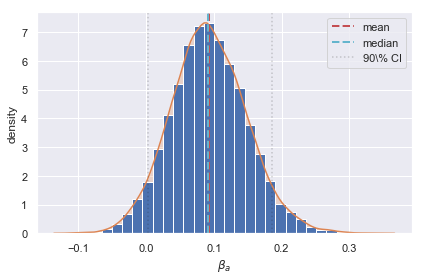

In [74]:
#Reminder of age coefficient from Model 2
plot_coeff(beta_a_2,r'$\beta_a$')